In [1]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [2]:
tif_path = "/Users/hester/Desktop/data/GBR_power-density_100m.tif"
UK_SHP = "/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

In [3]:
countries = gpd.read_file(UK_SHP)
uk = countries.loc[countries.get("ADMIN","")=="United Kingdom"].copy()
if uk.empty and "ISO_A3" in countries.columns:
    uk = countries.loc[countries["ISO_A3"]=="GBR"].copy()
uk = uk.dissolve()

In [4]:
dst_crs = "EPSG:27700"
uk_27700 = uk.to_crs(dst_crs)

In [5]:
with rasterio.open(tif_path) as src:
    print("RASTER CRS:", src.crs) 

    uk_in_src = uk.to_crs(src.crs)
    out_img, out_transform = mask(src, uk_in_src.geometry, crop=True, filled=True)

    data = out_img[0].astype("float32")
    nodata = src.nodata
    src_crs = src.crs

if nodata is not None:
    data[data == nodata] = np.nan
data[data <= 0] = np.nan 

RASTER CRS: EPSG:4326


In [6]:
h, w = data.shape

left = out_transform.c
top = out_transform.f
px_w = out_transform.a
px_h = out_transform.e
right = left + w * px_w
bottom = top + h * px_h
src_bounds = (left, bottom, right, top)

dst_transform, dst_w, dst_h = calculate_default_transform(
    src_crs, dst_crs, w, h, *src_bounds
)

dst = np.full((dst_h, dst_w), np.nan, dtype="float32")

reproject(
    source=data,
    destination=dst,
    src_transform=out_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest,
    src_nodata=np.nan,
    dst_nodata=np.nan
)

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 Affine(205.43525163043913, 0.0, -438535.518097813,
        0.0, -205.43525163043913, 1275078.7622855823))

In [7]:
bins = [-np.inf, 200, 300, 400, 500, 600, 800, np.inf]
cls = np.digitize(dst, bins, right=False).astype("float32")
cls[np.isnan(dst)] = np.nan

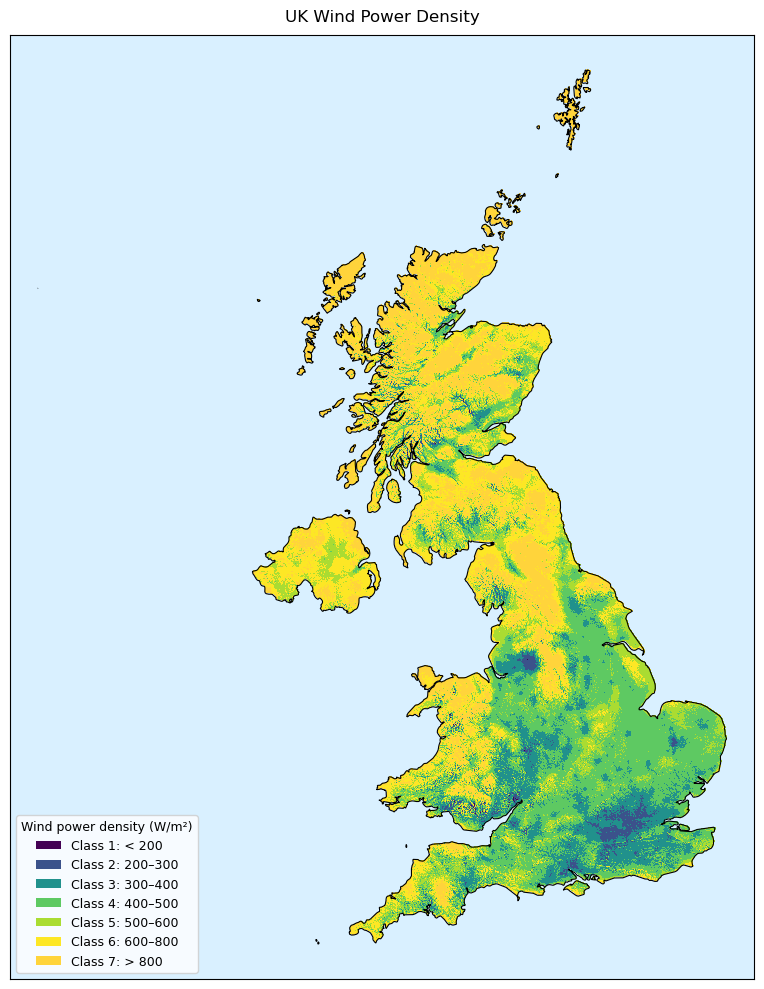

In [8]:
colors = ["#440154", "#3b528b", "#21918c", "#5ec962", "#aadc32", "#fde725", "#ffd43b"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.arange(1, 8+1), ncolors=cmap.N)

labels = [
    "Class 1: < 200","Class 2: 200–300","Class 3: 300–400","Class 4: 400–500",
    "Class 5: 500–600","Class 6: 600–800","Class 7: > 800"
]
legend_handles = [Patch(facecolor=colors[i], edgecolor="none", label=labels[i]) for i in range(7)]

fig, ax = plt.subplots(figsize=(8, 10))
SEA = "#d9f0ff"
ax.set_facecolor(SEA)

cmap2 = cmap.copy()
cmap2.set_bad(alpha=0.0)

left = dst_transform.c
top = dst_transform.f
px_w = dst_transform.a
px_h = dst_transform.e
H, W = cls.shape
right = left + W * px_w
bottom = top + H * px_h
extent = (left, right, bottom, top)

ax.imshow(cls, cmap=cmap2, norm=norm, extent=extent, interpolation="nearest", zorder=1)

uk_27700.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8, zorder=10)

minx, miny, maxx, maxy = uk_27700.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_aspect("equal", adjustable="box")
ax.set_title("UK Wind Power Density", fontsize=12, pad=10)

ax.legend(handles=legend_handles, title="Wind power density (W/m²)",
          loc="lower left", fontsize=9, title_fontsize=9)

ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()
fig.savefig("UK Wind Power Density.png", dpi=300)

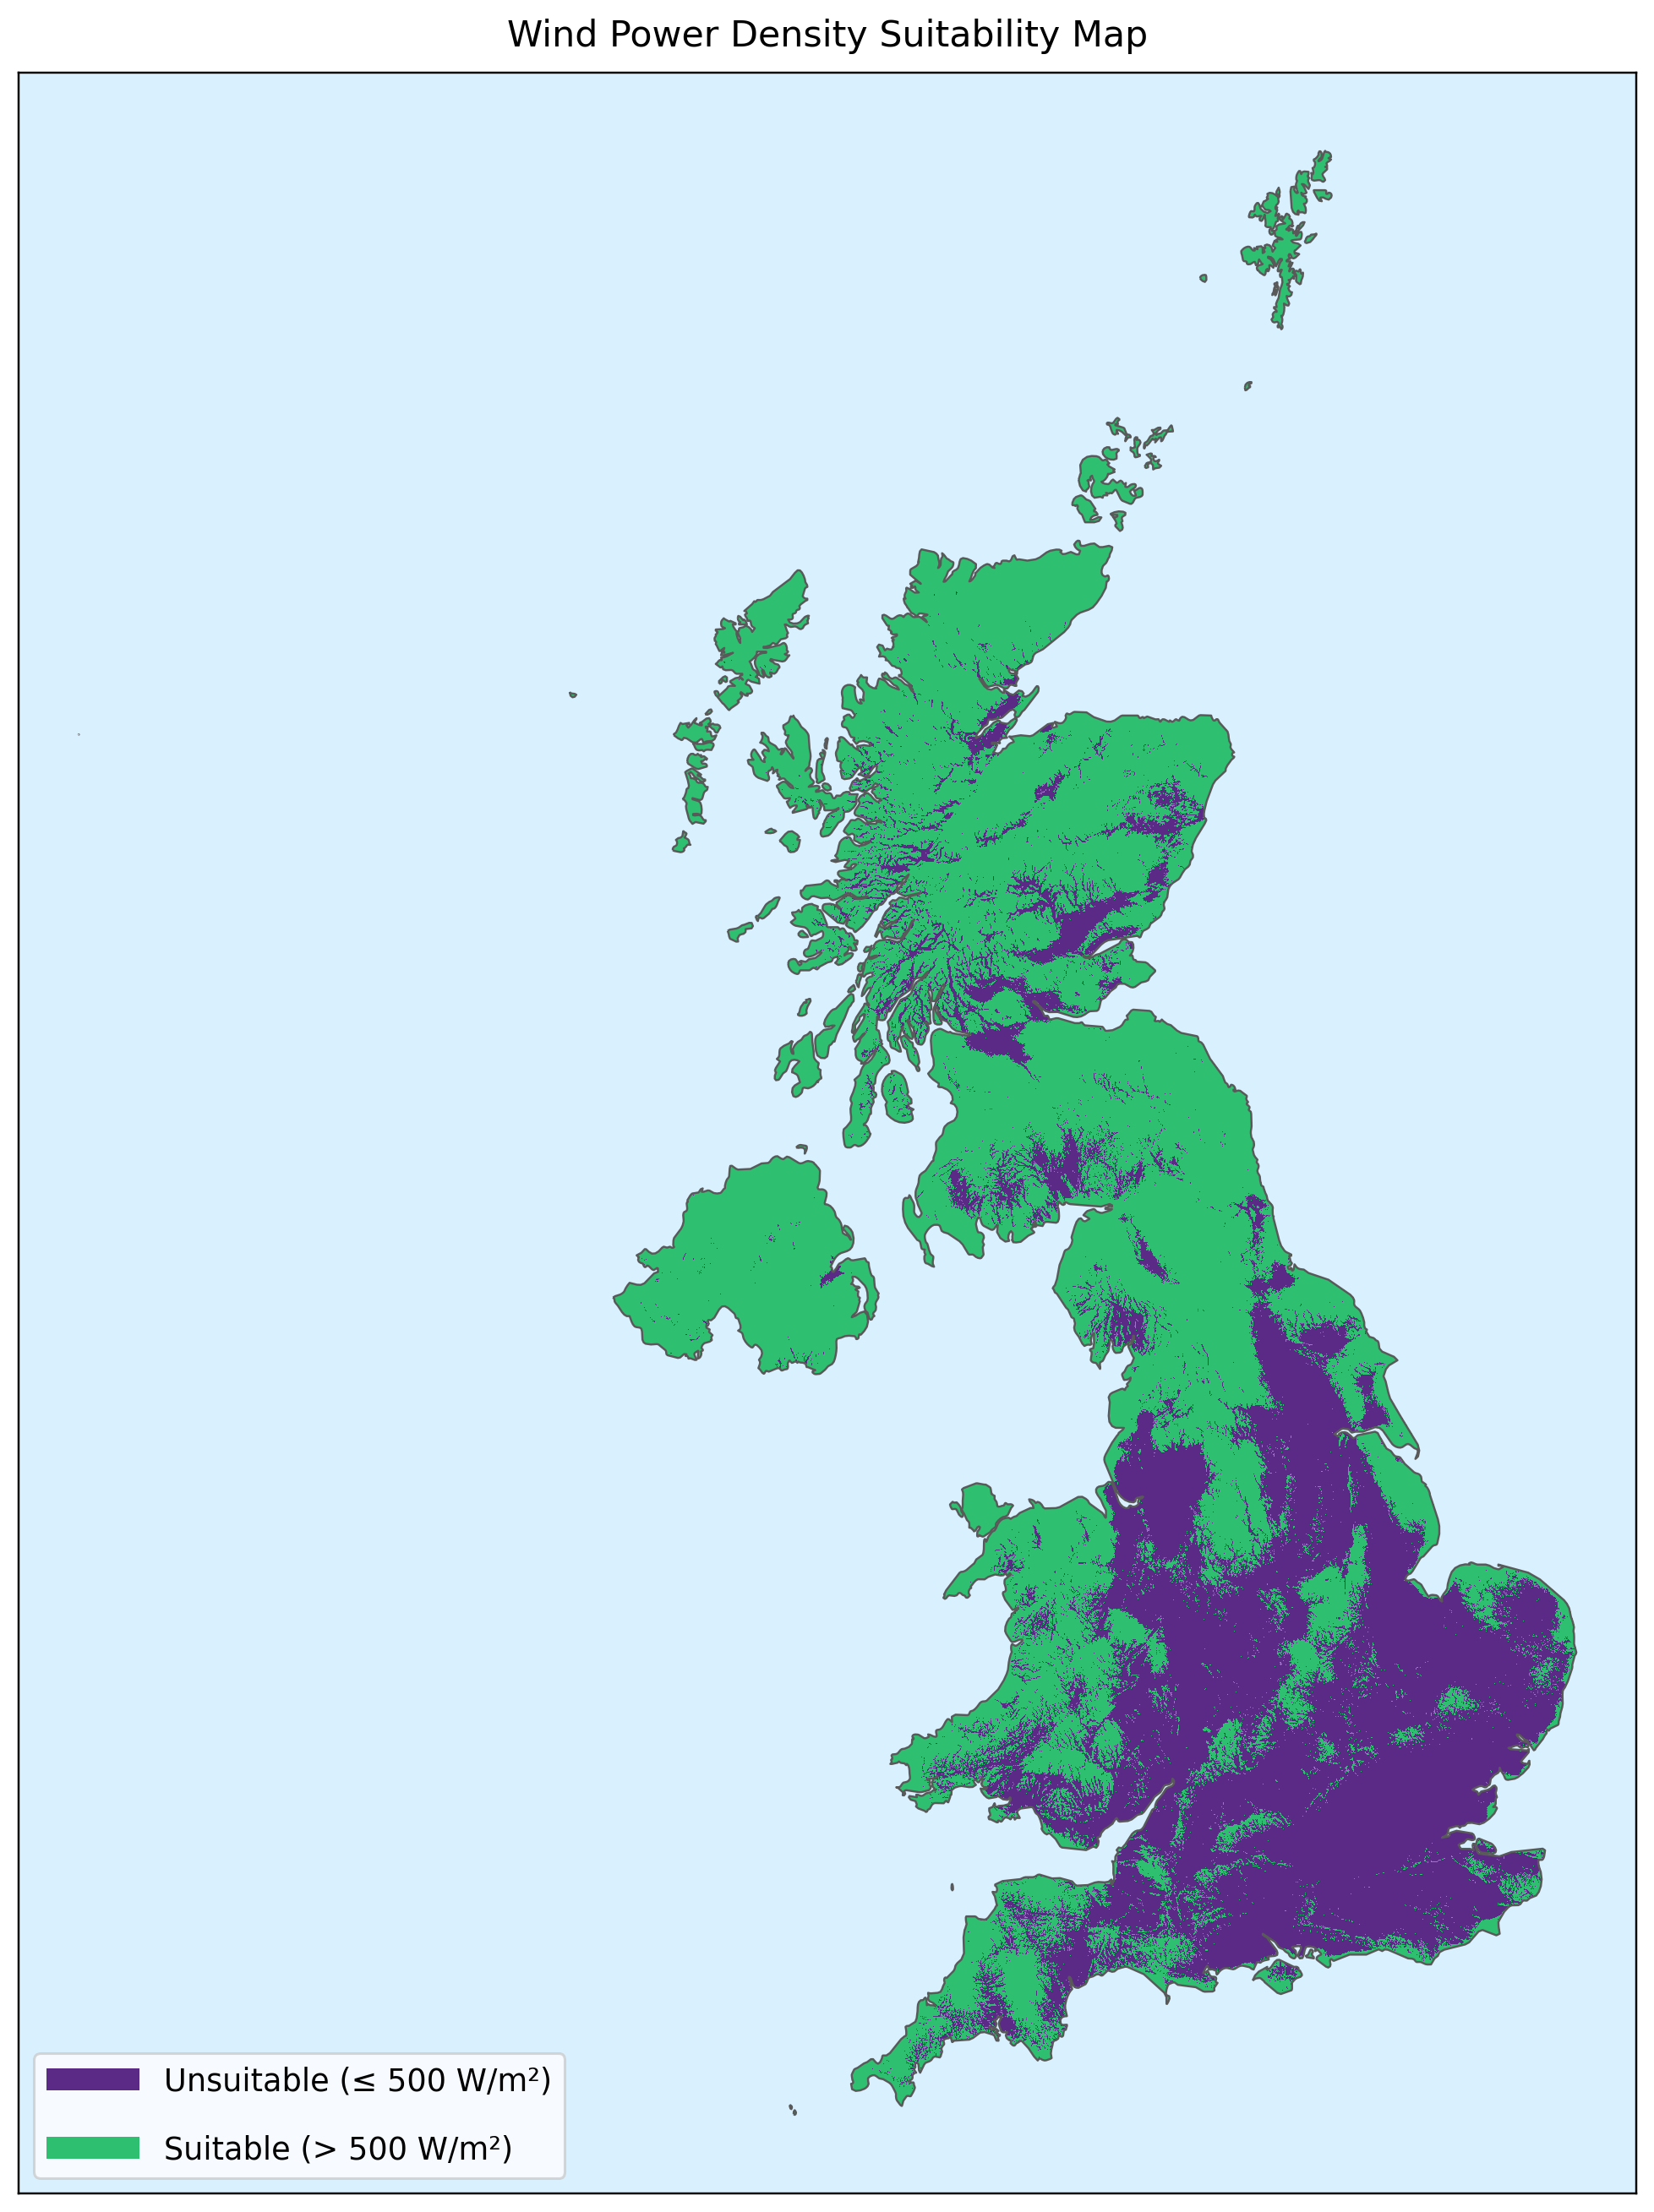

In [9]:
# 二值适宜性
thr = 500.0
suit = np.where(data > thr, 1, 0).astype("float32")
suit[np.isnan(data)] = np.nan  # 海洋/无数据 -> NaN

# UK边界投影到栅格CRS
uk_r = uk.to_crs(src_crs)


left = out_transform.c
top = out_transform.f
px_w = out_transform.a
px_h = out_transform.e
h, w = suit.shape
right = left + w * px_w
bottom = top + h * px_h
extent = (left, right, bottom, top)


fig, ax = plt.subplots(figsize=(9, 12), dpi=220)
SEA = "#d9f0ff"
ax.set_facecolor(SEA)

cmap = ListedColormap(["#5B2A86", "#2FBF71"])
cmap2 = cmap.copy()
cmap2.set_bad(alpha=0.0)  

ax.imshow(
    suit,
    cmap=cmap2,
    extent=extent,
    interpolation="nearest",
    zorder=1
)

uk_r.boundary.plot(
    ax=ax,
    color="0.35",
    linewidth=0.8,
    zorder=10
)

minx, miny, maxx, maxy = uk_r.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

if str(src_crs).endswith("27700") or "27700" in str(src_crs):
    ax.set_aspect("equal", adjustable="box")
else:
    ax.set_aspect("auto")

ax.set_title("Wind Power Density Suitability Map", fontsize=14, pad=10)

handles = [
    Patch(facecolor="#5B2A86", edgecolor="none", label=f"Unsuitable (≤ {int(thr)} W/m²)"),
    Patch(facecolor="#2FBF71", edgecolor="none", label=f"Suitable (> {int(thr)} W/m²)")
]
ax.legend(handles=handles, loc="lower left", fontsize=12, labelspacing=1.2,handlelength=3)

ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()
fig.savefig("Wind Power Density Suitability Map.png", dpi=300, bbox_inches="tight")